# Recurrent NN (LSTM) on equation of motion
The goal is to predict the trajectories of particles in a gravity field with help of a neuronal network. 
Therefore training data is generated by solving the equation of motion of the particle in the gravity field by solving numerically the differential equation. Later a recurrent neuronal network is trained on this data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import scipy as sc
from time import strftime
import tensorflow as tf
import tensorflow.keras as ks

random.seed(42) # for reproducibility

# Init of tensorboard
def log_dir(sub_dir='logs'):
    '''Function returns directory to store current tensorflow training log.
    Parameter:
        sub_dir <str> subdirectory to collect logs in
        
    Return:
        <path> Path composed of sub_dir and encoded system time
    '''
    return os.path.join(sub_dir, strftime('training_%Y_%m_%d_%H_%M_S'))
%load_ext tensorboard

2024-05-28 14:26:04.554070: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-28 14:26:04.611303: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-28 14:26:04.611921: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 14:26:05.523709: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Defining classes and functions to solve equation of motion

Physical problem: Finding trajectory of particle P_0. Forces on particle 0 are gravity from two bodies B_1, B_2. 
While B_1 rests in center of coordinate system, while B_2 moves around B_1 on a circular trajectory.

In [2]:
# Defining a class that holds all information about a particle or body
class space_body():
    '''Class that holds position and mass in properties. Returns distance to other objects
    by calling method "dist_to_object()" Returns array with own positions by calling method ".pos()".
    Methods:
        .dist_to_object(position) Returns distance to objects located at position, position: 2D list-like
        .pos() Returns 2D list-like of own position
        .normalized_diff_vector(position) Returns normalized differential vector pointing to object located at
                position, position: 2D list-like'''
    def __init__(self, position, mass, radius):
        self.x = position[0]
        self.y = position[1]
        self.m = mass
        self.r = radius
        
    def pos(self):
        return np.array([self.x, self.y])
        
    def dist_to_object(self, position):
        return np.sqrt((self.x - position[0])**2 + (self.y - position[1])**2)
    
    def normalized_diff_vector(self, position):
        abs_value = np.sqrt((position[0] - self.x)**2 + (position[1] - self.y)**2)
        return np.array([position[0] - self.x, position[1] - self.y]) / abs_value
    
# Defining a class that hold additionally its velocity
class space_particle(space_body):
    '''Class that holds position, mass and velocity in properties. 
    Additional properties t_series, pos_series, vel_series store result of integration of equation of motion:
    t: Stores time steps
    pos: stores position vectors as 2D array, shape (timesteps, 2)
    vel: stores velocity vectors as 2D array, shape (timesteps, 2)
    Returns distance to other objects by calling method "dist_to_object()".
    Integrates equation of motion with property .integrate(), see details in doc string of method'''
    def __init__(self, position, velocity, mass, radius):
        self.x = position[0]
        self.y = position[1]
        self.v_x = velocity[0]
        self.v_y = velocity[1]
        self.m = mass
        self.r = radius
        self.solution = pd.DataFrame()

    def RK_dy_dt(self, t, y, G, bodies):
        '''Defining right hand side of motions of equations, to be able to pass them to Runge Kutta solver
        Force on P_0 by B_1 causes acceleration. Velocities are easily obtained from vector y.'''
        # Writing new values to position and velocity of P_0 object
        self.x = y[0]
        self.y = y[1]
        self.v_x = y[2]
        self.v_y = y[3]
        
        # numeric values to sum up acceleration for x- and y-coordinate for every body, initialized with 0
        acc_x = 0
        acc_y = 0
        for i, body in enumerate(bodies):
            # Calculating absolut value of acceleration caused by gravitational force of each body on P_0
            if self.dist_to_object(body.pos()) < 0.01: # If true: avoid division by zero
                abs_acc = G * body.m * 0.01**(-2)
            else:
                abs_acc = G * body.m * self.dist_to_object(body.pos())**(-2)
            # Calculate x-component of acceleration
            acc_x += np.array([1, 0]) @ self.normalized_diff_vector(body.pos()) * abs_acc
            # Calculate y-component of acceleration
            acc_y += np.array([0, 1]) @ self.normalized_diff_vector(body.pos()) * abs_acc
        return [self.v_x, self.v_y, acc_x, acc_y]
    
    def integrate(self, G, bodies, t_span, n_points, rtol=1E-5):
        '''Integrate equation of motion in presence of Body. Parameters:
        G: gravitational constant
        Body: space_body object, gravitation force of this body will act on particle
        t_span: tuple of two numerical values, defining time interval of integration
        n_points: integer defining number of steps in result of integration
        rtol: numerical value defining tolerance for Runge-Kutta solver
        
        Has no return value, fills property DataFrame "solution" with result of integration'''
        integration = sc.integrate.solve_ivp(
            lambda t, y: self.RK_dy_dt(t, y, G, bodies), t_span=t_span, 
            y0=np.array([self.x, self.y, self.v_x, self.v_y]), 
            t_eval=np.linspace(t_span[0], t_span[1], n_points), rtol=1E-5
        )
        self.solution = self.solution.assign(
            t=integration.t,
            x=integration.y[0],
            y=integration.y[1],
            v_x=integration.y[2],
            v_y=integration.y[3]
        )
        return self
    
    def show_trajectory(self, bodies=None):
        '''Method to create an plot of trajectory (result of integration of equation of motion).
        Optional arguement "bodies", accepts list of space_body objects to be plottet additionally in plot'''
        fig, ax = plt.subplots()
        ax.set_xlabel('x-coordinate [a.u.]')
        ax.set_ylabel('y-coordinate [a.u.]')
        ax.set_aspect(aspect='equal', adjustable='box') # force same scale for both axes
        abs_max_axes = self.solution[['x', 'y']].abs().max().max() + 1# maximum of absolute values of coordinates x,y
        ax.set_xlim(-abs_max_axes, abs_max_axes)
        ax.set_ylim(-abs_max_axes, abs_max_axes)
        ax.scatter(self.solution.x, self.solution.y, c=self.solution.t, s=8)
        if bodies != None:
            for i, body in enumerate(bodies):
                # Draw n points on the radius of each space_body
                n = 50
                x_circle = np.array([body.r * np.sin(i*2*np.pi/n) for i in range(1, n+1)])
                y_circle = np.array([body.r * np.cos(i*2*np.pi/n) for i in range(1, n+1)])
                ax.scatter(body.x + x_circle, body.y + y_circle, c='k', s=12)
                
# Function to plot trajectories
def compare_trajectory(a, b):
    '''Function creates plot of two trajectories a, b. 
    a,b  have to be 2D arrays with shape (n, 2) with stored x- and y-positions'''
    fig, ax = plt.subplots()
    ax.set_xlabel('x-coordinate [a.u.]')
    ax.set_ylabel('y-coordinate [a.u.]')
    ax.set_aspect(aspect='equal', adjustable='box') # force same scale for both axes
    abs_max_axes = np.array(np.abs(a).max(), np.abs(b).max()).max() + 1# maximum of absolute values of coordinates x,y
    ax.set_xlim(-abs_max_axes, abs_max_axes)
    ax.set_ylim(-abs_max_axes, abs_max_axes)
    ax.scatter(a.T[0], a.T[1], c='black', s=8)
    ax.scatter(b.T[0], b.T[1], c='red', s=8)
                

### Example: Two space_body act on space_particle P_0

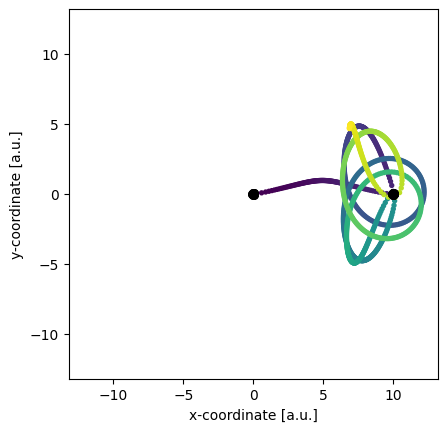

In [3]:
G = 1 # Gravitational constant

# Create body in center of coordinate system with big mass
B_1 = space_body(position=[0, 0], mass=1.0, radius=0.15)
# Create body in 10 unit distance along x from B_1
B_2 = space_body(position=[10, 0], mass=1.0, radius=0.15)

# Create particle that contains velocity, as well
P_0 = space_particle(position=[0.15, 0], velocity=[3.55, .455], mass=0.05, radius=0.05) 
# velocity=[3.55, .45]

# Integrate equation of motion in presence of B_1, B_2
P_0.integrate(G, [B_1, B_2], t_span=(0, 200), n_points=1000)
# Display result in a plot of trajectory
P_0.show_trajectory(bodies=[B_1, B_2])

## Generation of data for training and evaluation of Recurrent Neuronal Network

In [4]:
    
def gen_samples_launch_from_surface(n_samples, n_timesteps, 
                                    B=space_body(position=(0, 0), mass=10, radius=0.15),
                                    launch_pos=(0, 0.3), launch_velocity_x_window=(5, 8),
                                    launch_velocity_y_window=(0, 0), mass=0.1, radius=0.05, G=1):
    ''''''
    # Create tf.data.Dataset with random numbers as obtained from parametrized windows of velocity 

    
    vel_x_span = launch_velocity_x_window[1]-launch_velocity_x_window[0]
    vel_y_span = launch_velocity_y_window[1]-launch_velocity_y_window[0]
    for i in range(n_samples):    
        yield (
            space_particle(
                position=launch_pos, velocity=[
                    launch_velocity_x_window[0] + vel_x_span*np.random.random(),
                    launch_velocity_y_window[0] + vel_y_span*np.random.random()
                ], mass=mass, radius=radius
            )
            .integrate(G, [B], t_span=(0, 1), n_points=n_timesteps)
            .solution
        )

n_samples = 1000 # number of samples to create for Dataset
n_timesteps = 50 # total number of timesteps in every timeseries (including target)
n_target_steps = 10 # number of timesteps to be taken as targets (from the end of timeseries)

train_data = tf.data.Dataset.from_generator(
    lambda: gen_samples_launch_from_surface(n_samples, n_timesteps), 
    output_signature=tf.TensorSpec(shape=(n_timesteps, 5))
)

train_data = train_data.map(lambda x: (x[:-n_target_steps, 1:3], x[-n_target_steps:, 1:3]))
train_data = train_data.cache()
train_data = train_data.batch(32)

# Create validation data
n_samples = 50 # number of samples to create for Dataset
eval_data = tf.data.Dataset.from_generator(
    lambda: gen_samples_launch_from_surface(n_samples, n_timesteps), 
    output_signature=tf.TensorSpec(shape=(n_timesteps, 5))
)

eval_data = eval_data.map(lambda x: (x[:-n_target_steps, 1:3], x[-n_target_steps:, 1:3]))
eval_data = eval_data.cache()
eval_data = eval_data.batch(50)

# Create test data
n_samples = 10 # number of samples to create for Dataset
test_data = tf.data.Dataset.from_generator(
    lambda: gen_samples_launch_from_surface(n_samples, n_timesteps), 
    output_signature=tf.TensorSpec(shape=(n_timesteps, 5))
)

test_data = test_data.map(lambda x: (x[:-n_target_steps, 1:3], x[-n_target_steps:, 1:3]))
test_data = test_data.cache()
test_data = test_data.batch(10)

In [14]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(60, return_sequences=False, input_shape=(40, 2)))
model.add(tf.keras.layers.Dense(2*n_target_steps, activation='linear'))
model.add(tf.keras.layers.Reshape(target_shape=(n_target_steps, 2))
)

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
current_log_dir = log_dir()
tensorboard_cb = tf.keras.callbacks.TensorBoard(current_log_dir)
earlystopping_cb = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
model.compile(optimizer=optimizer, loss='mse')
model.fit(
    train_data, validation_data=eval_data, epochs=500, 
    callbacks=[tensorboard_cb, earlystopping_cb], verbose=0
)

In [7]:
%tensorboard --logdir=./logs

In [8]:
iterator = test_data.unbatch().as_numpy_iterator()

1/1 [==============================] - 0s 23ms/step


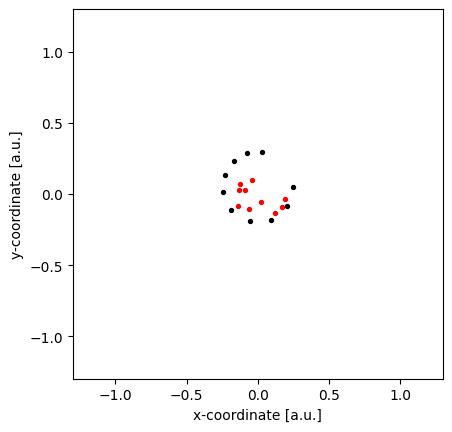

In [12]:
data = iterator.next()
prediction = model.predict(tf.expand_dims(data[0], 0))
target = data[1]
compare_trajectory(target, prediction)

In [247]:
# Define Recurrent Neuronal Network
RNN = ks.Sequential()
RNN.add(ks.layers.LSTM(2, input_shape=(n, 2), return_sequences=True))
RNN.add(ks.layers.LSTM(300, return_sequences=True))
RNN.add(ks.layers.LSTM(2, return_sequences=True, activation='linear'))

RNN.compile(loss='mean_squared_error', optimizer='adam')
history_buffer_loss = []

2023-05-10 13:57:06.103679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 13:57:06.106275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 13:57:06.108054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100
8/8 [==============================] - 2s 258ms/step - loss: 0.0538
Epoch 2/100
8/8 [==============================] - 2s 250ms/step - loss: 0.0538
Epoch 3/100
8/8 [==============================] - 2s 251ms/step - loss: 0.0508
Epoch 4/100
8/8 [==============================] - 2s 253ms/step - loss: 0.0475
Epoch 5/100
8/8 [==============================] - 2s 251ms/step - loss: 0.0487
Epoch 6/100
8/8 [==============================] - 2s 250ms/step - loss: 0.0482
Epoch 7/100
8/8 [==============================] - 2s 252ms/step - loss: 0.0465
Epoch 8/100
8/8 [==============================] - 2s 255ms/step - loss: 0.0459
Epoch 9/100
8/8 [==============================] - 2s 252ms/step - loss: 0.0467
Epoch 10/100
8/8 [==============================] - 2s 258ms/step - loss: 0.0449
Epoch 11/100
8/8 [==============================] - 2s 248ms/step - loss: 0.0467
Epoch 12/100
8/8 [==============================] - 2s 253ms/step - loss: 0.0543
Epoch 13/100
8/8 [===================

Text(0.5, 0.98, 'Loss function')

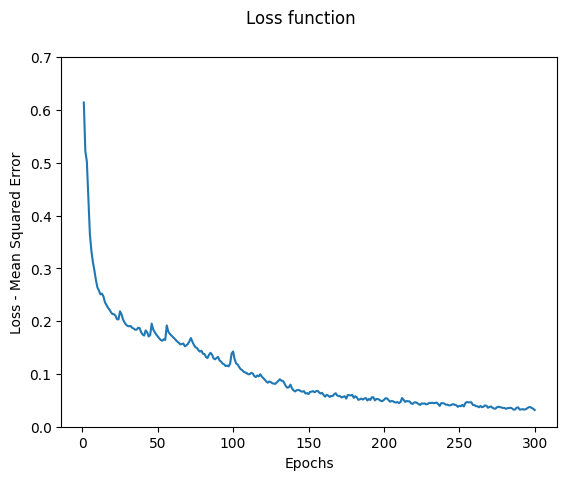

In [253]:
x_train = samples.copy()
x_train[:, -n//2:, :] = 0

history = RNN.fit(x=x_train, y=samples, batch_size=128, epochs=100)
history_buffer_loss += history.history['loss']
# Plotting loss function
fig, ax = plt.subplots()
ax.set_ylim(bottom=0, top=np.max(history_buffer_loss).round(1) + 0.1)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss - Mean Squared Error')
ax.plot(list(range(1, len(history_buffer_loss) + 1)), history_buffer_loss)
fig.suptitle('Loss function')

32/32 [==============================] - 2s 49ms/step
6.015015623761638


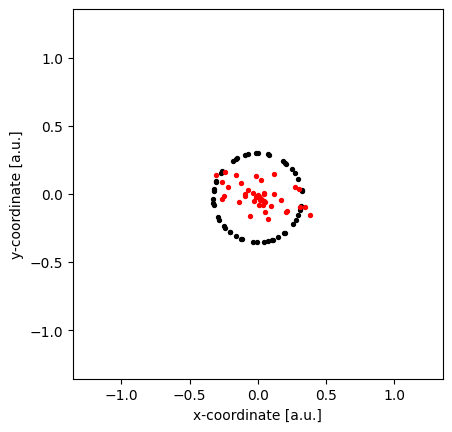

In [255]:
compare_nr = 9
compare_trajectory(samples[compare_nr, :, :], RNN.predict(x_train)[compare_nr, :, :])
print(random_list[compare_nr])

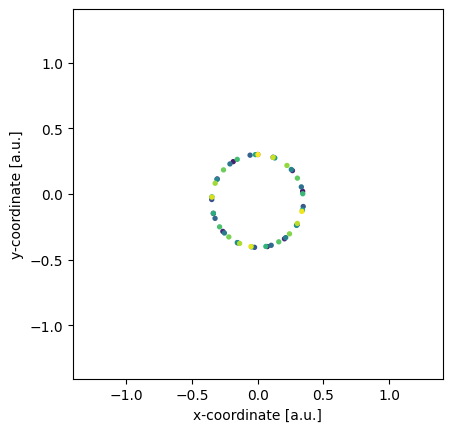

In [238]:
P_1 = space_particle(position=(0, 0.3), velocity=(6.2 , 0), mass=0.1, radius=0.05)
P_1.integrate(G, [B_3], t_span=(0, 15), n_points=50)
P_1.show_trajectory(bodies=[])